# CellRank meets CytoTRACE

:::{note}

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). You can also contact us using info@cellrank.org.  

:::

# Preliminaries

In this tutorial, you will learn how to:

- compute a developmental potential using our adapted CytoTRACE implementation {cite}`gulati:20`. 
- set up CellRank's {class}`~cellrank.kernels.CytoTRACEKernel` to compute a transition matrix based on the CytoTRACE score. 
- visualize the transition matrix in a low-dimensional embedding. 

Here's a conceptual overview of how we compute the CytoTRACE score:

:::{fig} fig-intro

<img src="_static/img/cytotrace_score.jpg" width="800px"  alt="CytoTRACE uses the number of genes expressed per cell to estimate a developmental potential.">

**CytoTRACE estimates differentiation potential***: Following the original CytoTRACE suggestion, we use the number of genes expressed per cell as a raw signal of differentiation status and apply several post-processing steps to increase robustness. The basic assumption behind this method is that naive cells on average express more genes compared to mature cells because they regulate their chromatin less tightly; we've observed this to work well for many early developmental datasets.  

:::

:::{note}

A bottleneck in the original implementation was scalabilty of the post-processing steps; we therefore adapted the original CytoTRACE implementation to be much faster and memory efficient. 

:::

<img src="_static/img/cytotrace_scalability.jpg" width=600  
alt="CellRank scales CytoTRACE to over 1M cells.">

**Fig** | While the original implementation breaks down at 100k cells on our servers, CellRank easily scales to 1.3M cells in less than 100 sec. 

On a few datasets encompassing different single-cell technologies and biological systems, we validated that the two implementations give the same results: 

<img src="_static/img/cytotrace_score_validation.png" width=800
alt="The adapted implementation is as accurate as the original.">

**Fig** | CellRank faithfully implements the CytoTRACE score. 

**a.** Low-dimensional representation of 22,370 embryonic *C.elegans* muscle and mesoderm cells <cite data-cite="packer:19"></cite> colored according to the CytoTRACE pseudotime (left: CellRank implementation, middle: original CytoTRACE implementation <cite data-cite="gulati:20"></cite>) and ground truth embryo time from the original publication. 

**b.** Scatter plot comparing both implementations across 6 datasets; x-axis (y-axis) represents Spearman's rank correlation between CellRank (original) CytoTRACE pseudotime and embryo time, averaged per embryo time-point. In the legend, the number behind each dataset denotes Person correlation between the two implementations. CellRank's accelerated implementation correlates highly with the original implemetation and agrees with grount-truth embryo times as well as the original implementation. 

**Method**: To get from the CytoTRACE pseudotime to a directed transition matrix, we use the general mechanism described in the [pseudotime tutorial](https://cellrank.readthedocs.io/en/stable/cellrank_meets_pseudotime.html). To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of zebrafish embryogenesis assayed using drop-seq, restricted to the axial mesoderm lineage <cite data-cite="farrell:18"></cite>. 

<div class="alert alert-info">
Important

If you want to run this on your own data, you will need...

- a scRNA-seq dataset which satisfies the CytoTRACE assumptions, i.e., naive cell states should on avarage express more genes. This is often the case for early develpmental stages. 

</div> 

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/cellrank_meets_cytotrace.ipynb).

## Import packages & data

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

Global seed set to 0


In [3]:
adata = cr.datasets.zebrafish()
adata

AnnData object with n_obs × n_vars = 2434 × 23974
    obs: 'Stage', 'gt_terminal_states', 'lineages'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors'
    obsm: 'X_force_directed'

This zebrafish dataset contains 12 time-points spanning 3.3 - 12 hours past fertilization. We can use the original force-directed layout to plot cells, colored by developmental stage:

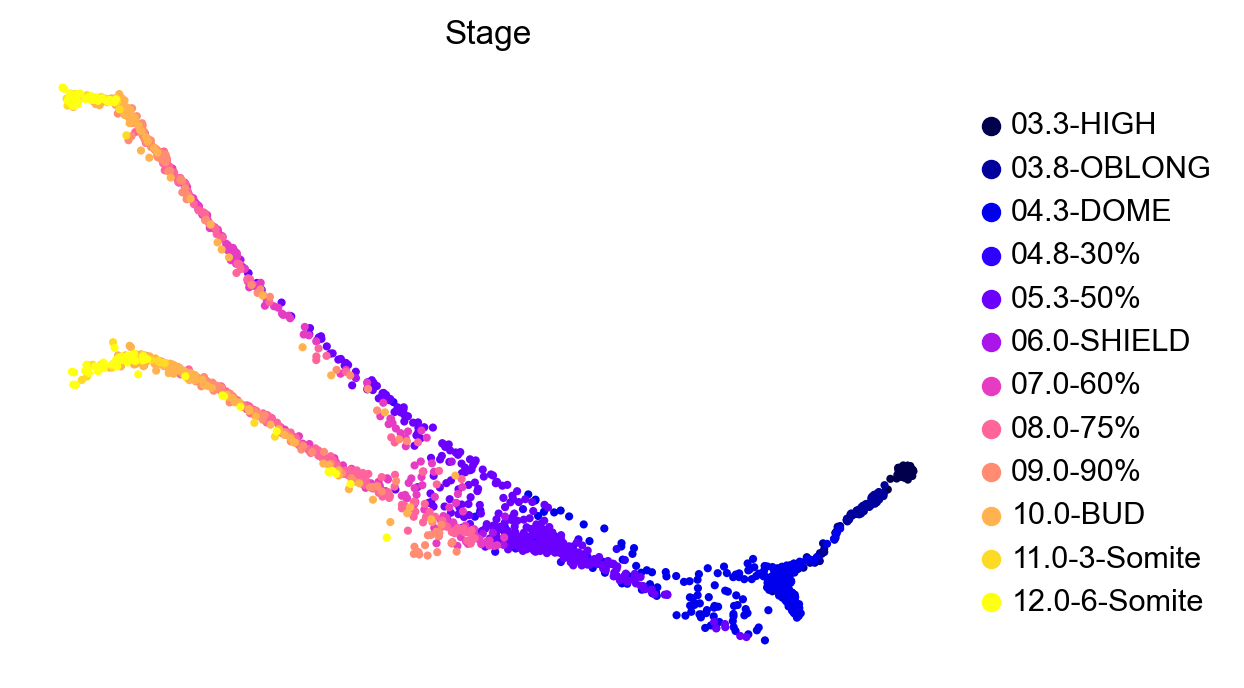

In [4]:
scv.pl.scatter(adata, basis="force_directed", c="Stage", legend_loc="right")

We can further look into the lineage assignments, computed in the original study using URD <cite data-cite="farrell:18"></cite>: 

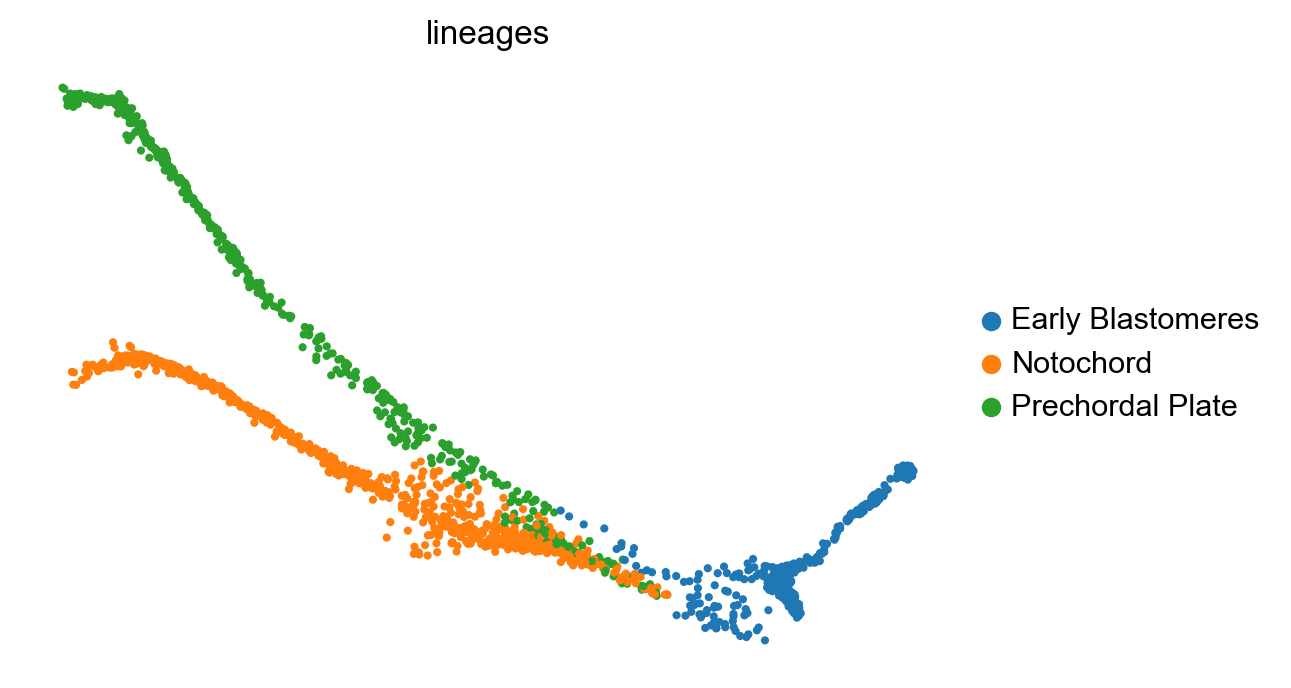

In [5]:
scv.pl.scatter(adata, basis="force_directed", c="lineages", legend_loc="right")

## Pre-process the data

Before we can start applying the CytoTRACE kernel, we'll have to do some basic pre-processing of the data. 

In [6]:
# filter, normalize total counts and log-transform
sc.pp.filter_genes(adata, min_cells=10)
scv.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# hvg annotation
sc.pp.highly_variable_genes(adata)
print(f"This detected {adata.var['highly_variable'].sum()} highly variable genes. ")

# use scVelo's `moments` function for imputation - note that hack we're using here:
# we're copying our `.X` matrix into the layers because that's where `scv.tl.moments`
# expects to find counts for imputation
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Normalized count data: X.
This detected 2392 highly variable genes. 
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Initialize the CytoTRACE kernel

Import the kernel, initialize it using the pre-processed AnnData object and compute the CytoTRACE score: 

In [7]:
from cellrank.kernels import CytoTRACEKernel

ctk = CytoTRACEKernel(adata).compute_cytotrace()

Computing CytoTRACE score with `13690` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)


We can visually check that our computed CytoTRACE pseudotime correlates well with ground-truth real-time annotations:

/Users/marius/Projects/scvelo/scvelo/plotting/utils.py:967: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/marius/Projects/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


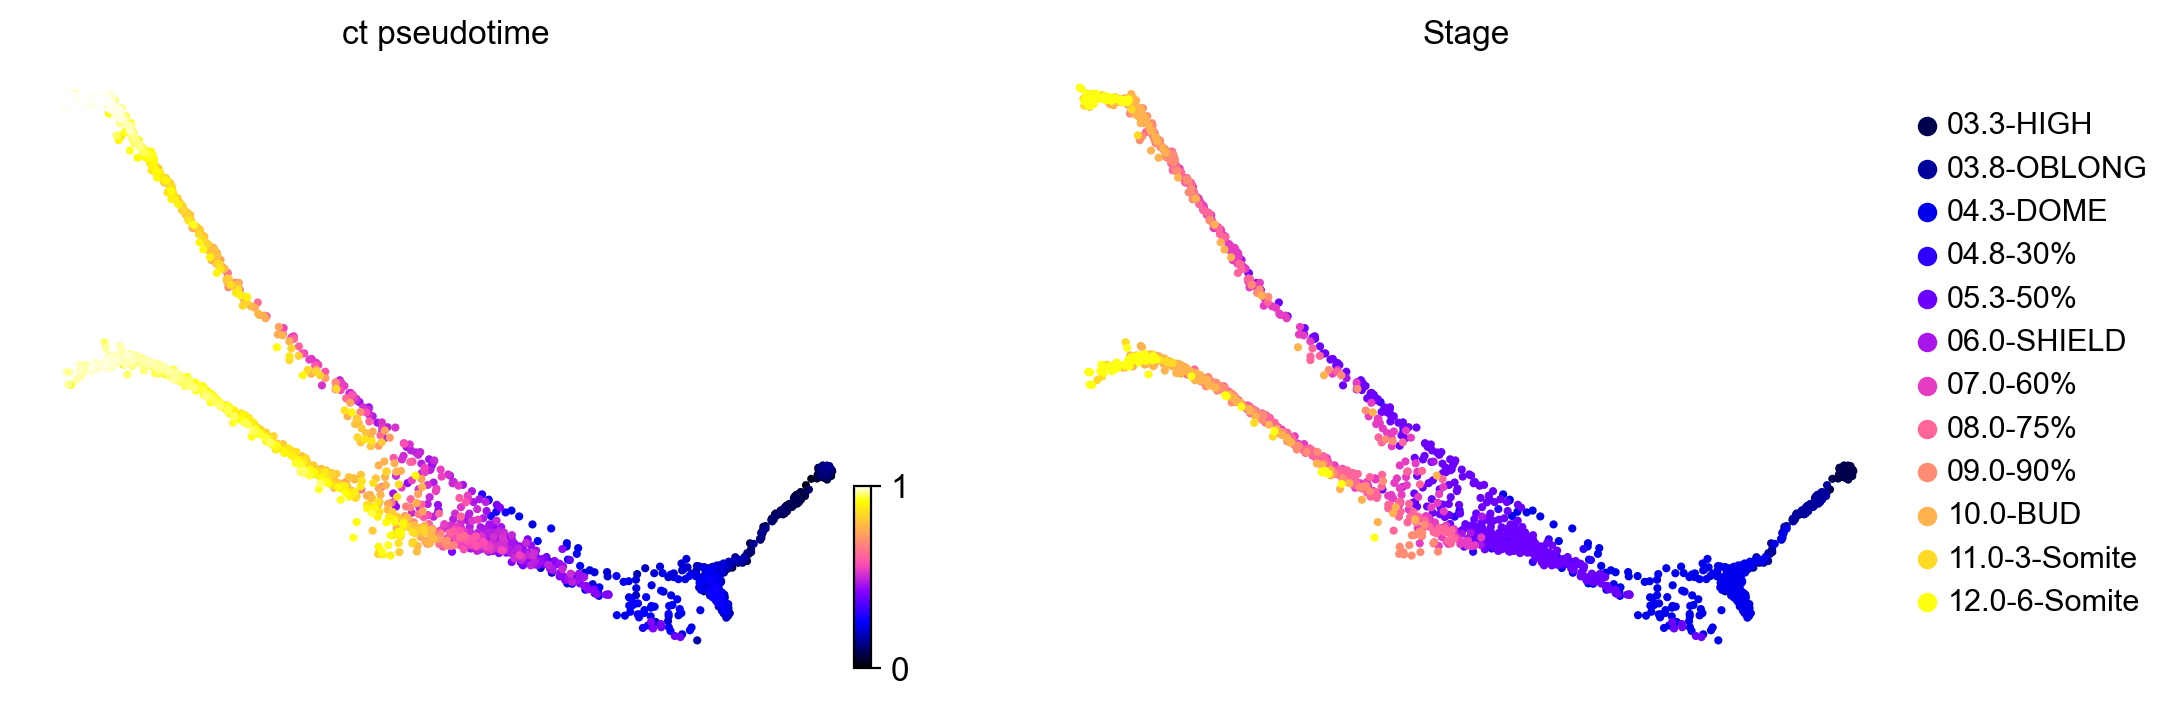

In [8]:
scv.pl.scatter(
    adata,
    c=["ct_pseudotime", "Stage"],
    basis="force_directed",
    legend_loc="right",
    color_map="gnuplot2",
)

To make this a bit more quantitative, we can look at the distribution of our pseudotime over real-time-points and show this via violin plots:

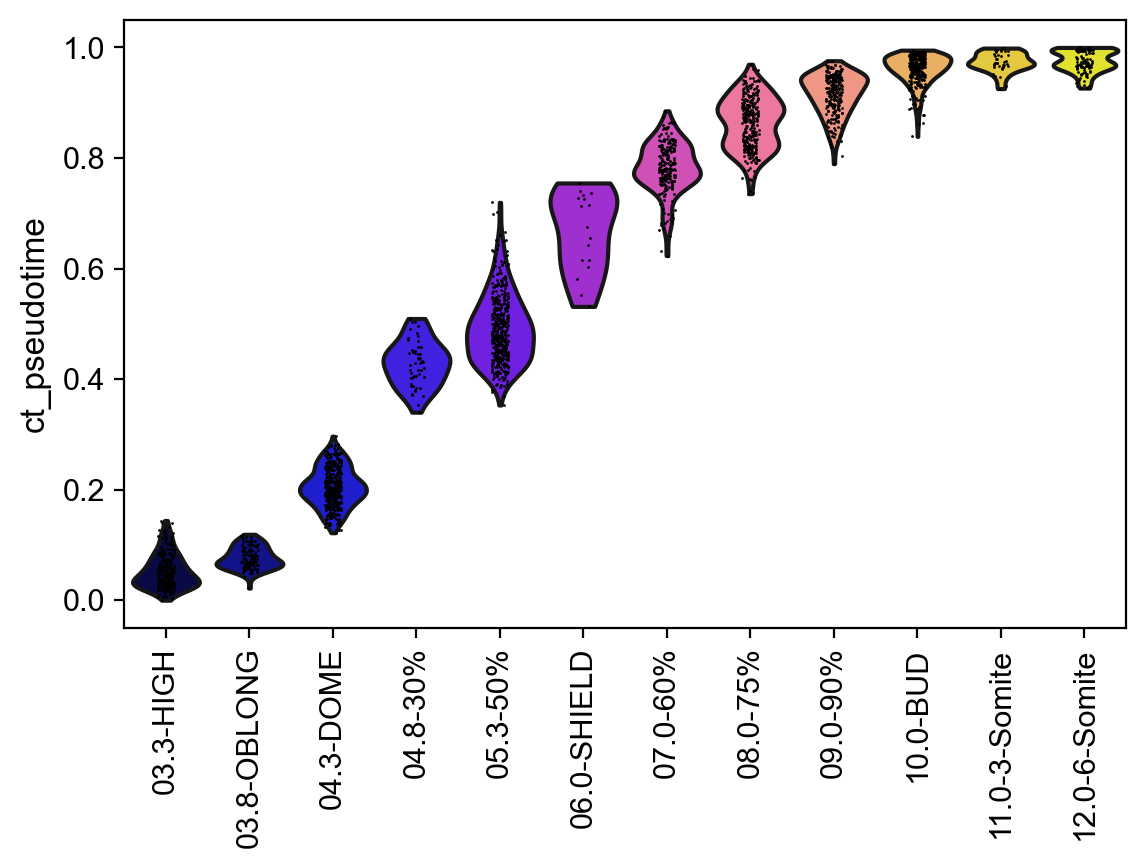

In [9]:
sc.pl.violin(adata, keys=["ct_pseudotime"], groupby="Stage", rotation=90)

This looks good! The CytoTRACE pseudotime can thus be used to bias graph edges into the direction of increasing differentiation status, similar to how we did this for other pseudotimes in the [PseudotimeKernel tutorial](https://cellrank.readthedocs.io/en/stable/cellrank_meets_pseudotime.html). 

## Compute & visualize a transition matrix

Compute the transition matrix:

In [10]:
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)

Computing transition matrix based on pseudotime`


  0%|          | 0/2434 [00:00<?, ?cell/s]

    Finish (0:00:01)


CytoTRACEKernel[n=2434, dnorm=False, scheme='soft', b=10.0, nu=0.5]

To get some intuition for this transition matrix, we can project it into an embedding and draw the same sort of arrows that we all got used to from RNA velocity - the following plot will look **exactly** like the plots you're used to from scVelo for visualizing RNA velocity <cite data-cite="bergen:20,manno:18"></cite>. 

<div class="alert alert-info">
Important

There's **no RNA velocity** here, we're visualizing the directed transition matrix we computed using the kNN graph as well as the CytoTRACE pseudotime.

</div> 

Projecting transition matrix onto `force_directed`
Adding `adata.obsm['T_fwd_force_directed']`
    Finish (0:00:00)


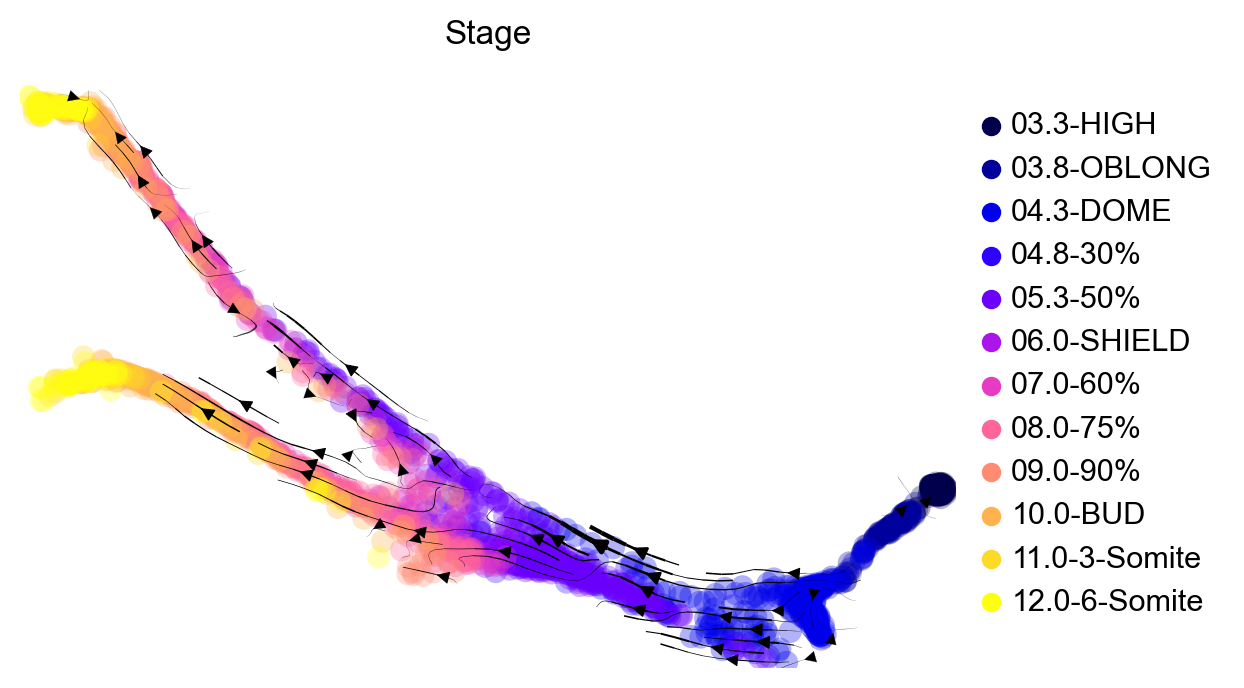

In [11]:
ctk.plot_projection(basis="force_directed", color="Stage", legend_loc='right')

The process of differentiation seems to be captured well by this transition matrix. We can visually confirm this by looking at terminal-state annotations from the original study: 

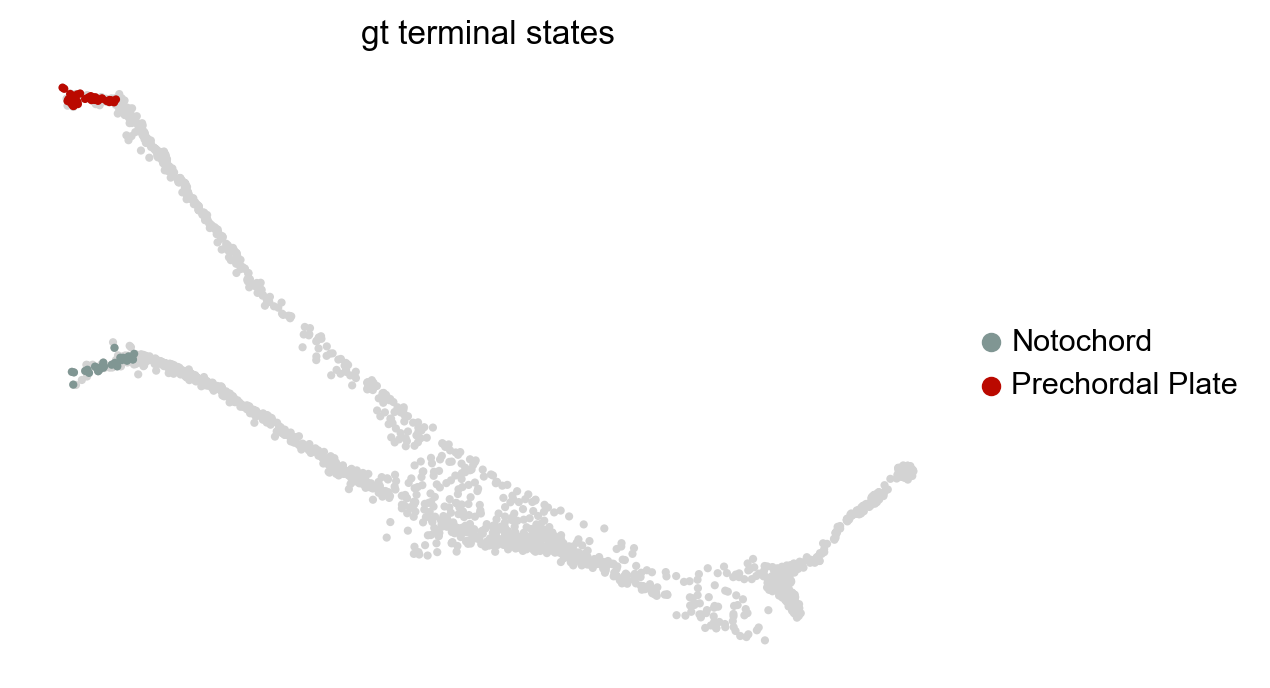

In [12]:
scv.pl.scatter(
    adata, basis="force_directed", c="gt_terminal_states", legend_loc="right"
)

Another way to gain intuition for the transition matrix is by drawing some cells from the early stage and to use these as starting cells to simulate random walks on the transition matrix:

Simulating `15` random walks of maximum length `609`


  0%|          | 0/15 [00:00<?, ?sim/s]

    Finish (0:00:00)
Plotting random walks


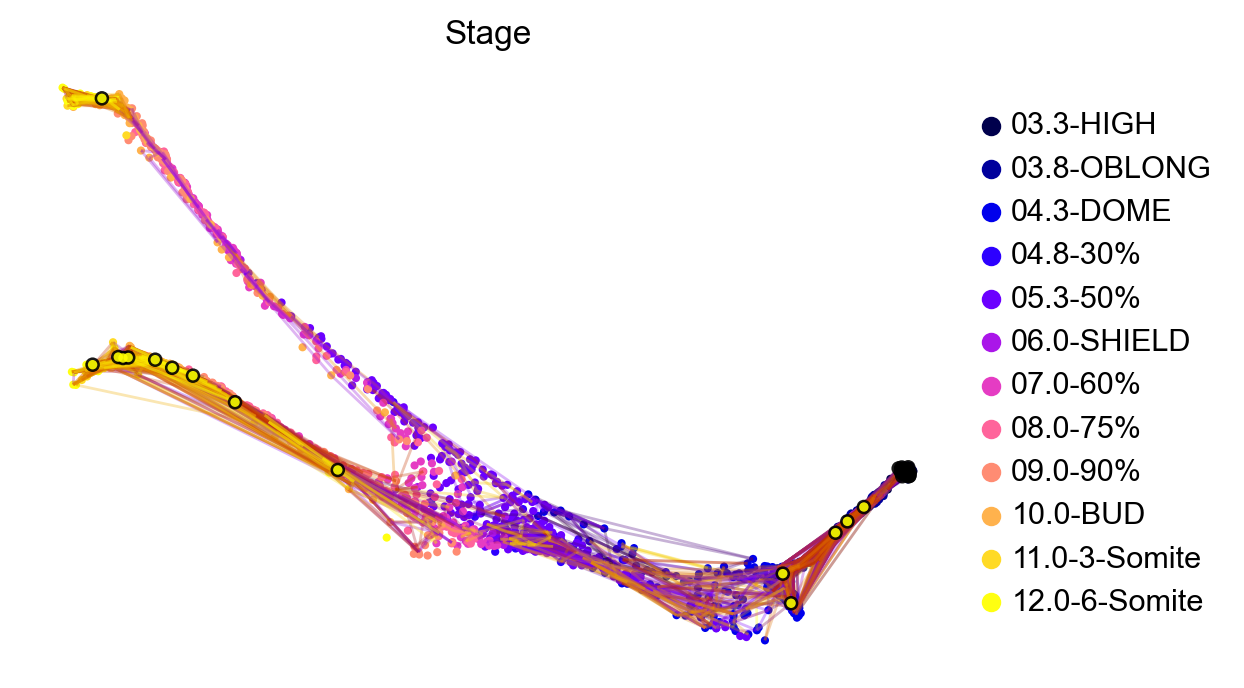

In [13]:
ctk.plot_random_walks(
    n_sims=15,
    start_ixs={"Stage": "03.3-HIGH"},
    basis="force_directed",
    color="Stage",
    legend_loc="right",
    seed=1,
)

Black dots denote sampled starting cells for random walks, yellow dots denote end cells. We terminated each random walk after a predefined number of steps. Random walks are colored according to how long they've been running for - i.e. the initial segments are more black/blue whereas the late segments are more orange/yellow. We can see that most random walks terminate in one of the two terminal states, as expected. 

<div class="alert alert-info">
Important

The visualization techniques demonstrated here work for **every kernel**, no matter whether it's a [VelocityKernel](https://cellrank.readthedocs.io/en/stable/cellrank_meets_rna_veloctiy.html), [PseudotimeKernel](https://cellrank.readthedocs.io/en/stable/cellrank_meets_pseudotime.html), [CytoTRACEKernel](https://cellrank.readthedocs.io/en/stable/cellrank_meets_cytotrace.html) or some other kernel.

</div> 

## What's next? 

In this tutorial, you learned how to use CellRank to compute a transition matrix based on the CytoTRACE pseudotime and how it can be visualized in low dimensions. The real power of CellRank comes in when you use estimators to analyze the transition matrix directly, rather than projecting it. For the next steps, we recommend...

- going through the [initial & terminal states tutorial](https://cellrank.readthedocs.io/en/stable/initial_terminal.html) to learn how to use the transition matrix to automatically identify initial and terminal states. 
- taking a look at the [full API](https://cellrank.readthedocs.io/en/stable/api.html) to learn about parameter values you can use to adapt these computations to your data. 
- reading the original CytoTRACE publication and considering limitations of this appraoch <cite data-cite="gulati:20"></cite>. 

<div class="alert alert-info">
Important

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). 

</div> 

## Package versions

In [14]:
cr.logging.print_versions()

cellrank==1.5.1+gedbc651e scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2
